In [1]:
from pvdeg import TEST_DATA_DIR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pvdeg
import os

# Irradiance

The amount of radiant flux received by a surface per unit area. For our cases we will use units of $\frac{W}{m^2}$ although there are many different units commonly used.

# Chamber Irradiance

To control the irradiance of your simulated chamber test you can define a column of irradiance setpoints. The difficulty arises because the setpoints column names are arbitrary. Any column name in your CSV will work as long as it has the corresponding ramp rate colum. For a column of name "arbitrary" the ramp rate column looks like "arbitrary_ramp".  

Currently, the `chamber` module only supports two plug and play options for irradiance setpoints. As follows
- "irradiance_340" which represents the irradiance at 340 nm in W/m^2
- "irradiance_full" which represents full spectrum irradiance in W/m^2. This uses the [ASTM G173-03 AM1.5 spectrum](https://www.nrel.gov/grid/solar-resource/spectra-am1.5.html).

This choice was made because UV wavelengths cause the most degredation in PV materials with degredation rate approaching zero as we trend to high wavelengths.

## Example With Irradiance at 340 nm
The file below is the same one used in ["Chamber.ipynb"](Chamber.ipynb). It contains setpoints for temperature, % relative humidity and UV irradiance at 340 nm.


In [2]:
chamber = pvdeg.Chamber(
    fp=os.path.join(TEST_DATA_DIR, "chamber-setpoints.csv"), # use a setpoints file in the test folder
    setpoint_names=["temperature", "relative_humidity", "irradiance_340"],
    skiprows=[1]
)

chamber.setpoints.head()

,setpoint_temperature,setpoint_relative_humidity,setpoint_irradiance_340
0 days 00:00:00,25.0,50.0,0.0
0 days 00:01:00,90.0,30.0,0.55
0 days 00:02:00,90.0,30.0,0.55
0 days 00:03:00,90.0,30.0,0.55
0 days 00:04:00,90.0,30.0,0.55


### Calculating Full Spectrum GTI, #1

Converting irradiance at 340 nm to full spectrum irradiance using the [ASTM G173-03 AM1.5 spectrum](https://www.nrel.gov/grid/solar-resource/spectra-am1.5.html) is easy using `pvdeg.spectral.get_GTI_from_irradiance_340`. The code block below outputs the full spectrum irradiance at each timestep in the simulated chamber.

This example is trivial because we have constant setpoint values.

0 days 00:00:00            0.0
0 days 00:01:00    1096.460463
0 days 00:02:00    1096.460463
0 days 00:03:00    1096.460463
0 days 00:04:00    1096.460463
Name: GTI, dtype: object


<Axes: title={'center': 'Full Spectrum Irradiance Calculated from 340 nm'}>

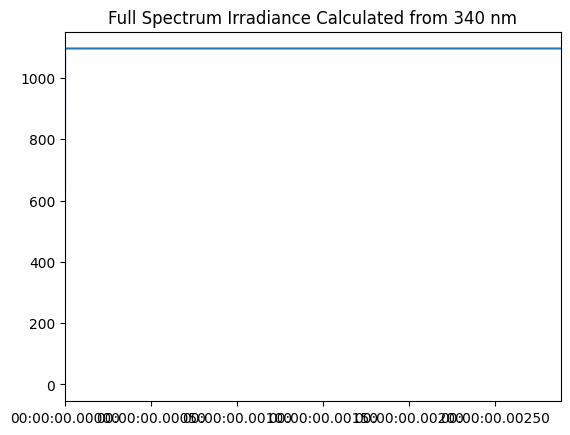

In [ ]:
gti = pvdeg.spectral.calc_full_from_irradiance_340(chamber.setpoints["setpoint_irradiance_340"])
print(gti.head())
gti.plot(title="Full Spectrum Irradiance Calculated from 340 nm")

### Calculating Full Spectrum GTI non-trivial

Lets create a csv with only an "irradiance_340" and temperature setpoints. See the documentation setpoints page in the User Guide for clarification. We are going to define the csv without creating a file below, this is only for demonstration purposes.  

The example below will have ramped rates and multiple setpoint values. These will have no units in the CSV. 

In [4]:
import csv
import io

csv_data = [
    ["step_length", "step_divisions", "temperature", "temperature_ramp", "irradiance_340", "irradiance_340_ramp"],
    [1, 1, 50, 0, 0, 0],
    [3, 3, 50, 0, 0.3, 0.1],
    [1, 1, 50, 0, 0, 0],
    [5, 5, 50, 0, 0.55, 0.2]
]

csv_file = io.StringIO()
csv_writer = csv.writer(csv_file)
csv_writer.writerows(csv_data)
csv_file.seek(0)

# this is the normal entrance point to creating a chamber object for pvdeg analysis
uv_chamber = pvdeg.Chamber(
    fp=csv_file,
    setpoint_names=["irradiance_340", "temperature"]
)

### Display

To see the chamber setpoints after reading a file we can run use `chamber.setpoints` or `display(chamber)` or in a jupyter notebook just `chamber`.

In [5]:
uv_chamber.setpoints

,setpoint_irradiance_340,setpoint_temperature
0 days 00:00:00,0.3,50.0
0 days 00:01:00,0.3,50.0
0 days 00:02:00,0.3,50.0
0 days 00:03:00,0.0,50.0
0 days 00:04:00,0.0,50.0
0 days 00:05:00,0.275,50.0
0 days 00:06:00,0.55,50.0
0 days 00:07:00,0.55,50.0
0 days 00:08:00,0.55,50.0


,setpoint_irradiance_340,setpoint_temperature
0 days 00:00:00,0.3,50.0
0 days 00:01:00,0.3,50.0
0 days 00:02:00,0.3,50.0
0 days 00:03:00,0.0,50.0
0 days 00:04:00,0.0,50.0
0 days 00:05:00,0.275,50.0
0 days 00:06:00,0.55,50.0
0 days 00:07:00,0.55,50.0
0 days 00:08:00,0.55,50.0

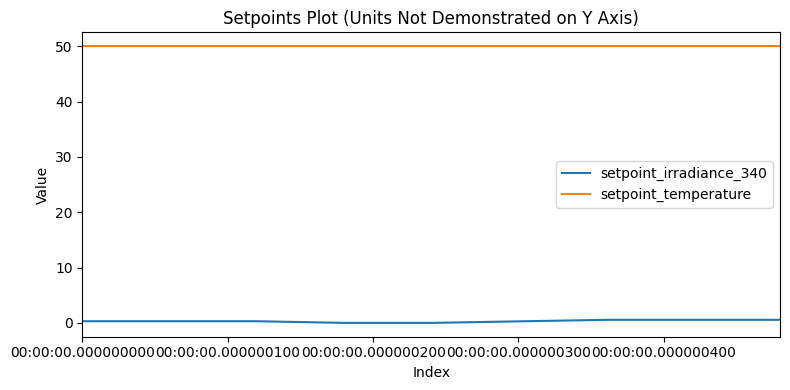

In [6]:
display(uv_chamber)

,setpoint_irradiance_340,setpoint_temperature
0 days 00:00:00,0.3,50.0
0 days 00:01:00,0.3,50.0
0 days 00:02:00,0.3,50.0
0 days 00:03:00,0.0,50.0
0 days 00:04:00,0.0,50.0
0 days 00:05:00,0.275,50.0
0 days 00:06:00,0.55,50.0
0 days 00:07:00,0.55,50.0
0 days 00:08:00,0.55,50.0

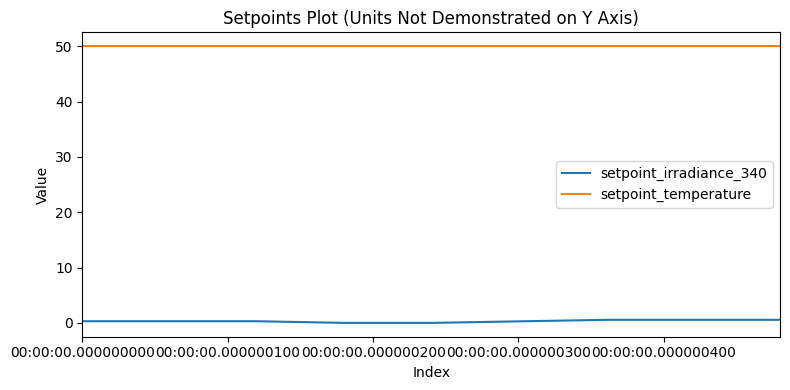

In [7]:
uv_chamber

### Viewing Setpoints

Use the `Chamber.plot_setponts()` method to see the setpoint values.

<Axes: title={'center': 'Irradiance @ 340 nm (UV)'}>

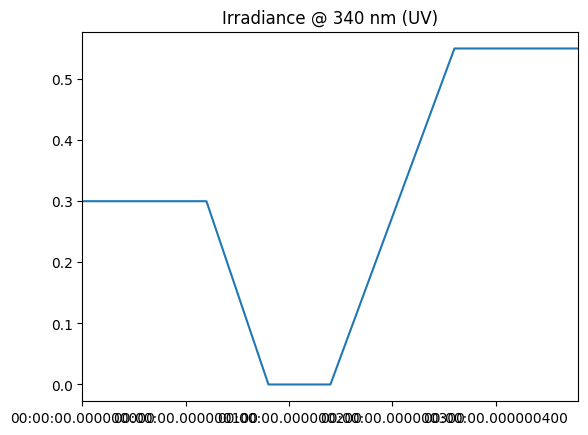

In [12]:
uv_chamber.setpoints["setpoint_irradiance_340"].plot(title="Irradiance @ 340 nm (UV)")

### Calculating Full Spectrum GTI, #2

Now we can use the GTI method to calculate the GTI at each timestep.

In [ ]:
gti = uv_chamber.full_from_irradiance_340()
gti

0 days 00:00:00     598.069344
0 days 00:01:00     598.069344
0 days 00:02:00     598.069344
0 days 00:03:00            0.0
0 days 00:04:00            0.0
0 days 00:05:00     548.230232
0 days 00:06:00    1096.460463
0 days 00:07:00    1096.460463
0 days 00:08:00    1096.460463
Name: setpoint_irradiance_full, dtype: object

<Axes: title={'center': 'Full Spectrum Irradiance'}>

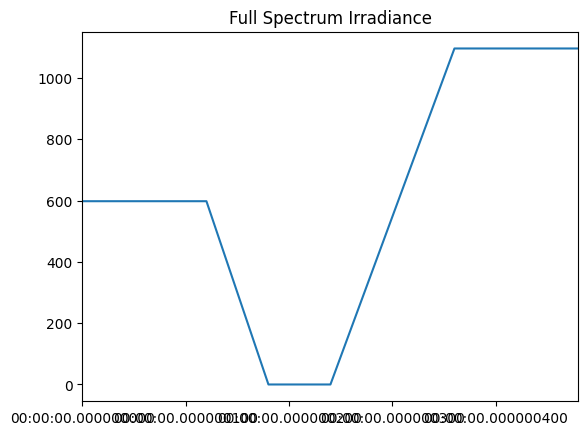

In [11]:
gti.plot(title="Full Spectrum Irradiance")

# How Does Irradiance Affect Temperature 

Intuitively, accumulated irradiance over a timestep will increase the temperature of a sample within our chamber. If a step is 0 seconds we will have a 0 degree increase in temperature caused by irradiance. Similarly, the longer the exposure, the more irradiance will cause the temperature to increase. We have 2 finite difference temperature models. One includes irradiance while the other doesn't.

- `fdm_temperature`
- `fdm_temperature_irradiance`

The model used for the chamber calculations depends on input. Currently we can only use irradiance at 340 nm, "irradiance_340" or full spectrum irradiance "irradiance_full" to use the better irradiance dependent temperature model for the sample temperature calculation. Otherwise we will fall back to the naive model that does not factor in irradiance.

### Temperature Model Parameters

We need to define sample dimensions for a rectangular module in meters. We also need to set an absorptance of the test sample. We also provide the equilibriation times for the chamber $\tau_c$ and the sample $\tau_s$. 

In [13]:
uv_chamber.setDimensions(length=0.15, width=0.15) # or we can directly access the attributes
uv_chamber.setAbsorptance(absorptance=0.95)

uv_chamber.calc_temperatures(air_temp_0=25, sample_temp_0=25, tau_c=1, tau_s=15)

## Temperature Plot

Below we have a code block to calculate temperature of the air in the chamber and the sample in the chamber. This model factors in irradiance. The background is highlihted yellow at times where the full spectrum irradiance is above 200 $\frac{w}{m^2}$. Note that the temperature increases faster when the lamp is on in the test chamber. Additionally, the temperature increase is slower when the lamp is off.

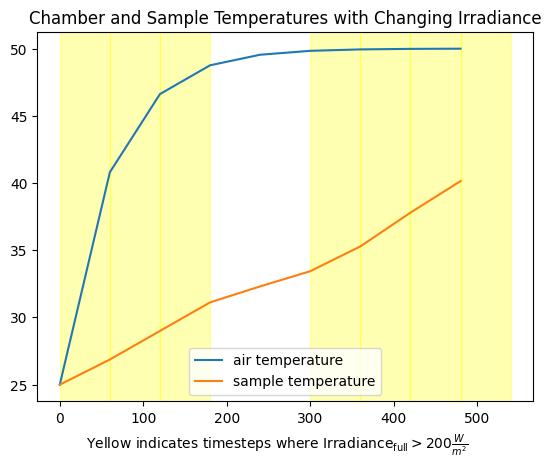

In [27]:
fig, ax = plt.subplots()

ax.plot(uv_chamber.air_temperature, label="air temperature")
ax.plot(uv_chamber.sample_temperature, label="sample temperature")
plt.title("Chamber and Sample Temperatures with Changing Irradiance")

for idx, value in gti.items():
    if value > 200:
        ax.axvspan(idx.total_seconds(), idx.total_seconds() + 60, color='yellow', alpha=0.3)

plt.figtext(0.5, 0.01, "Yellow indicates timesteps where $\\text{Irradiance}_{\\text{full}} > 200 \\frac{W}{m^2}$", fontsize="10", ha="center")
plt.legend()